In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import errstate, isneginf
import pandas as pd
from math import log2
from itertools import combinations
from matplotlib import pyplot as plt
from utils import *

In [3]:
from matplotlib import rcParams, cm
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn')

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

rcParams['axes.titlesize'] = 15
rcParams['axes.labelsize'] = 15
rcParams['figure.titlesize'] = 15

In [4]:
trainW = WordCounter(get_tokenized_sentences('data/trainW_token_end.txt'))
trainT = WordCounter(get_tokenized_sentences('data/trainT_token_end.txt'))
test1 = WordCounter(get_tokenized_sentences('data/test1_token_end.txt'))
test2 = WordCounter(get_tokenized_sentences('data/test2_token_end.txt'))
train_easy = WordCounter(get_tokenized_sentences('data/train_easy_token_end.txt'))
test_easy = WordCounter(get_tokenized_sentences('data/test_easy_token_end.txt'))
train_debug = WordCounter(get_tokenized_sentences('data/train_debug_token_end.txt'))
test_debug = WordCounter(get_tokenized_sentences('data/test_debug_token_end.txt'))

# ngram model

### Unigram model

In [5]:
unigram_model_trainW = UnigramModel(trainW, k=1)

for text in [trainW, trainT, test1, test2]:
    print(unigram_model_trainW.calculate_avg_ll(text))

-18.497573151470494
-18.555918913789192
-18.547618544163544
-18.54868310979827


In [6]:
unigram_model_trainW = UnigramModel(trainW, k=1)
unigram_model_trainW.calculate_avg_ll(trainT)

-18.555918913789192

In [7]:
unigram_model_trainT = UnigramModel(trainT, k=0)
unigram_model_trainT.calculate_avg_ll(trainT)

-9.313125075365638

In [8]:
unigram_model_trainT = UnigramModel(trainT, k=1)

for text in [trainW, trainT, test1, test2]:
    print(unigram_model_trainT.calculate_avg_ll(text))

-18.4748498669285
-9.32131744722474
-9.561877655497758
-10.221724078549878


In [78]:
def get_unigram_percents(train_counter, k, unigram_order=None):
    unigram_model = UnigramModel(train_counter, k)
    if unigram_order is None:
        unigram_percents = {unigram: prob*100 for unigram, prob in sorted(unigram_model.train_probs.items(), key=lambda item: item[1], reverse=True)}
        unigrams = [unigram[0] for unigram in unigram_percents.keys()]
        percents = list(unigram_percents.values())
    else:
        unigrams = unigram_order.copy()
        percents = [unigram_model.train_probs.get((unigram,), 0)*100 for unigram in unigrams]
    
    return unigrams, percents

In [194]:
unigramsT, percentsT = get_unigram_percents(trainT, k=0)
unigramsT = unigramsT[:301]
percentsT = percentsT[:301]

In [195]:
unigramsW, percentsW = get_unigram_percents(trainW, k=0, unigram_order=unigramsT)
unigrams1, percents1 = get_unigram_percents(test1, k=0, unigram_order=unigramsT)
unigrams2, percents2 = get_unigram_percents(test2, k=0, unigram_order=unigramsT)

In [254]:
unigramsTsmooth, percentsTsmooth = get_unigram_percents(trainT, k=6.7, unigram_order=unigramsT)
unigramsTsmooth_hard, percentsTsmooth_hard = get_unigram_percents(trainT, k=107, unigram_order=unigramsT)

In [288]:
N = trainT.token_count
V = len(trainT.all_ngram_counts[1])
uniform_prob = 1/(V+1)

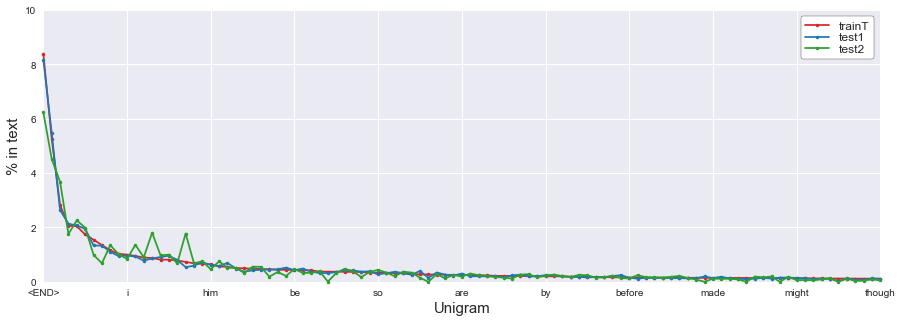

In [291]:
fig, ax = plt.subplots(figsize=(15, 5))
xlim = 101
ax.plot(percentsT[:xlim], '.-', label='trainT', color='tab:red', clip_on=False)
ax.plot(percents1[:xlim], '.-', label='test1', color='tab:blue', clip_on=False)

# ax.plot(percentsTsmooth[:xlim], '.-',label='trainT (20% uniform)', color='tab:orange', clip_on=False)
ax.plot(percents2[:xlim], '.-', label='test2', color='tab:green', clip_on=False)
# ax.plot(percentsTsmooth_hard[:xlim], '.-',label='trainT (80% uniform)', color='tab:brown', clip_on=False)
# ax.plot(percentsW[:xlim], '.-', label='trainW', color='black', clip_on=False)
# ax.plot([uniform_prob]*xlim, '.-', label='uniform', color='gray', clip_on=False)

xticks = range(0, xlim+1, 10)
xticklabels = np.array(unigramsT)[xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.legend(**legend_opts)
ax.set_xlim(0, xlim-1)
ax.set_ylim(0, 10)
ax.set_xlabel('Unigram')
ax.set_ylabel('% in text')

fig.savefig('viz/word_dist_T12.png')
plt.show()

### Higher ngram models

In [346]:
short_names = ['train_easy', 'test_easy', 'train_debug', 'test_debug', 'trainW', 'trainT', 'test1', 'test2']
file_names_lookup = {name: f'data/{name}_token_end.txt' for name in short_names}

In [347]:
train_easy_padded = WordCounter(get_tokenized_sentences('data/train_easy_token_end.txt', padding=1))
test_easy_padded = WordCounter(get_tokenized_sentences('data/test_easy_token_end.txt', padding=1))

In [349]:
class MultigramModel:
    def __init__(self, train, n, k=0):
        self.n = n
        self.vocab_size = len(train.all_ngram_counts[1]) - 1
        self.ngram_condprobs = {}
        
        # Calculate general conditional probability for ngram
        for ngram, ngram_count in train.all_ngram_counts[self.n].items():
            prevgram = ngram[:-1]
            condprob_nom = ngram_count['all'] + k
            condprob_denom = train.all_ngram_counts[self.n - 1][prevgram]['all'] + (self.vocab_size+1) * k
            self.ngram_condprobs[ngram] = condprob_nom / condprob_denom

            if prevgram + ('<UNK>',) not in self.ngram_condprobs:
                self.ngram_condprobs[prevgram + ('<UNK>',)] = k / condprob_denom
                    
    def calculate_avg_ll(self, test):
        self.test_ll = 0
        self.test_info = {}
        for ngram, ngram_count in test.all_ngram_counts[self.n].items():
            prevgram = ngram[:-1]
            if ngram in self.ngram_condprobs:
                ngram_prob = self.ngram_condprobs[ngram]
            elif prevgram + ('<UNK>',) in self.ngram_condprobs:
                ngram_prob = self.ngram_condprobs[prevgram + ('<UNK>',)]
            else:
                ngram_prob = 1 / (self.vocab_size+1)
            
            ngram_ll = log2(ngram_prob)
            self.test_info[ngram] = {'prob': ngram_prob, 'log': ngram_ll, 'count': ngram_count['all']}
            self.test_ll += ngram_ll * ngram_count['all']
        
        self.test_avg_ll = self.test_ll / test.token_count
        return self.test_avg_ll

In [350]:
def get_avg_ll_ngram_model(train_shortname, test_shortname, n, k):
    train_padded = WordCounter(get_tokenized_sentences(file_names_lookup[train_shortname], padding=n-1))
    test_padded = WordCounter(get_tokenized_sentences(file_names_lookup[test_shortname], padding=n-1))
    ngram_model = MultigramModel(train_padded, n=n, k=k)
    test_avg_ll = ngram_model.calculate_avg_ll(test_padded)
    return ngram_model

In [1918]:
for n in [3, 4, 5]:
    print(n)
    print('WW:', get_avg_ll_ngram_model('trainW', 'trainW', n=n, k=0).test_avg_ll)
    print('WT:', get_avg_ll_ngram_model('trainW', 'trainT', n=n, k=0).test_avg_ll)
    print('TT:', get_avg_ll_ngram_model('trainT', 'trainT', n=n, k=1).test_avg_ll)
    print('TW:', get_avg_ll_ngram_model('trainT', 'trainW', n=n, k=1).test_avg_ll)

3
-2.8493390070185494
0.0
-11.82821593114744
-17.497578998730724
4
-1.5223295044336076
0.0
-12.102048803310892
-17.497578998730724
5
-1.284816019240453
0.0
-12.143324444645534
-17.497578998730724


# Interpolation

In [293]:
class CondProb:
    def __init__(self, train):
        self.start_condprobs = {}
        self.general_condprobs = {}
        self.uniform_prob = 1 / (len(train.all_ngram_counts[1]) + 1)

        for unigram, unigram_count in train.all_ngram_counts[1].items():
            if unigram_count['start']:
                self.start_condprobs[unigram] = unigram_count['start'] / train.sentence_count
            self.general_condprobs[unigram] = unigram_count['all'] / train.token_count

        for n in range(2, 6):
            start_prevgram_cumprobs = {}
            general_prevgram_cumprobs = {}
            for ngram, ngram_count in train.all_ngram_counts[n].items():
                prevgram = ngram[:-1]
                if ngram_count['start']:
                    start_condprob = ngram_count['start'] / train.all_ngram_counts[n - 1][prevgram]['start']
                    self.start_condprobs[ngram] = start_condprob
                    start_prevgram_cumprobs[prevgram] = start_prevgram_cumprobs.get(prevgram, 0) + start_condprob

                general_condprob = ngram_count['all'] / train.all_ngram_counts[n - 1][prevgram]['all']
                self.general_condprobs[ngram] = general_condprob
                general_prevgram_cumprobs[prevgram] = general_prevgram_cumprobs.get(prevgram, 0) + general_condprob

            for prevgram, cumprob in start_prevgram_cumprobs.items():
                assert isclose(cumprob, 1, rel_tol=1e-5)
            for prevgram, cumprob in general_prevgram_cumprobs.items():
                assert isclose(cumprob, 1, rel_tol=1e-5)

    def get_test_condprobs(self, test_file):
        test_token_count = sum(len(sentence) for sentence in get_tokenized_sentences(test_file))
        test_condprobs = np.zeros((test_token_count, 7))
        test_condprobs[:, 0] = self.uniform_prob

        row = 0
        for sentence_index, sentence in enumerate(get_tokenized_sentences(test_file)):
            for i, token in enumerate(sentence):
                test_condprobs[row, 6] = sentence_index
                for n in range(1, 6):
                    ngram_start = i + 1 - n
                    ngram_end = i + 1
                    if ngram_start >= 0:
                        ngram = tuple(sentence[ngram_start:ngram_end])
                        test_condprobs[row, n] = self.general_condprobs.get(ngram, 0)
                    else:
                        start_ngram = tuple(sentence[0:ngram_end])
                        test_condprobs[row, n] = self.start_condprobs.get(start_ngram, 0)

                row += 1

        return test_condprobs

In [294]:
condprob_modelW = CondProb(trainW)
test_condprobsWW = condprob_modelW.get_test_condprobs('data/trainW_token_end.txt')
test_condprobsWT = condprob_modelW.get_test_condprobs('data/trainT_token_end.txt')

In [295]:
condprob_modelT = CondProb(trainT)
test_condprobsTW = condprob_modelT.get_test_condprobs('data/trainW_token_end.txt')
test_condprobsTT = condprob_modelT.get_test_condprobs('data/trainT_token_end.txt')
test_condprobsT1 = condprob_modelT.get_test_condprobs('data/test1_token_end.txt')
test_condprobsT2 = condprob_modelT.get_test_condprobs('data/test2_token_end.txt')

In [296]:
tokens_T = [token for sentence in get_tokenized_sentences('data/trainT_token_end.txt') for token in sentence]
tokens_W = [token for sentence in get_tokenized_sentences('data/trainW_token_end.txt') for token in sentence]
tokens_1 = [token for sentence in get_tokenized_sentences('data/test1_token_end.txt') for token in sentence]
tokens_2 = [token for sentence in get_tokenized_sentences('data/test2_token_end.txt') for token in sentence]

In [297]:
def convert_prob_mat_to_df(prob_mat, text_tokens):
    df = pd.DataFrame(prob_mat)
    df.rename({6: 'sentence'}, axis=1, inplace=True)
    df.insert(0, 'token', text_tokens)
    df['sentence'] = df['sentence'].astype(int)
    return df

In [298]:
TT_df = convert_prob_mat_to_df(test_condprobsTT, tokens_T)
WT_df = convert_prob_mat_to_df(test_condprobsWT, tokens_T)
TW_df = convert_prob_mat_to_df(test_condprobsTW, tokens_W)
T1_df = convert_prob_mat_to_df(test_condprobsT1, tokens_1)
T2_df = convert_prob_mat_to_df(test_condprobsT2, tokens_2)

In [316]:
def calculate_avg_ll(test_condprobs, cols, weights=None):
    if weights is None:
        weights = np.ones(len(cols)) / len(cols)
    assert isclose(sum(weights), 1, rel_tol=1e-5)
    return np.log2((test_condprobs[:, cols] * np.array(weights)).sum(axis=1)).mean()

In [317]:
def plot_interpolate_with_uniform(ax, test_condprobs, ngram_weights, legend=False, ylim=(-20, 0), cmap=cm.winter_r, plot_text=True):
    ns = list(range(1, 6))

    for i, ngram_weight in enumerate(ngram_weights[::-1]):
        avg_lls = []
        for n in ns:
            avg_ll = calculate_avg_ll(test_condprobs, [0, n], weights=[1-ngram_weight, ngram_weight])
            avg_lls.append(avg_ll)

        ax.plot(ns, avg_lls, 'o-', label=f'{ngram_weight:.2f}', color=cmap(ngram_weight))
        if plot_text and (i == 0 or i == len(ngram_weights) - 1):
            ax.text(n+0.1, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=15, va='center', color=cmap(ngram_weight))
    if legend:
        ax.legend(title='Fraction of\nngram model', bbox_to_anchor=(1.04, 0), loc='lower left', **legend_opts)
        
    ax.set_xticks(range(1, 6))
    ax.set_yticks(np.arange(ylim[0], ylim[1]+1, 5))
    ax.set_xlim(0, 6)
    ax.set_ylim(ylim)
    
    ax.set_xlabel('ngram')
    ax.set_ylabel('Average log likelihood')

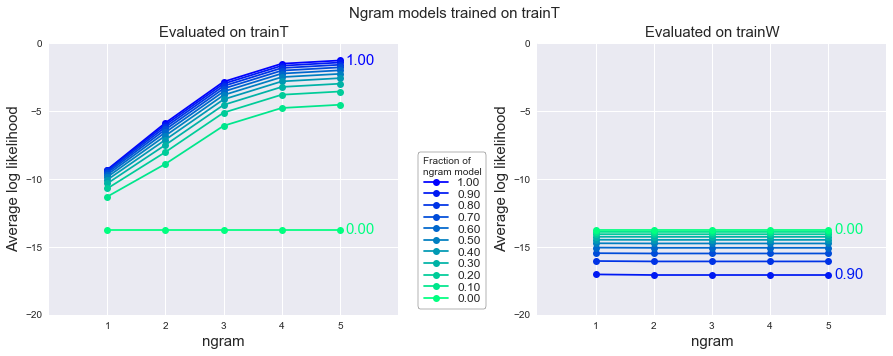

In [318]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Ngram models trained on trainT')
plt.subplots_adjust(wspace=0.4)

plot_interpolate_with_uniform(ax[0], test_condprobsTT, np.arange(0, 1.01, 0.1), legend=True)
plot_interpolate_with_uniform(ax[1], test_condprobsTW, np.arange(0, 0.95, 0.1))
ax[0].set_title('Evaluated on trainT')
ax[1].set_title('Evaluated on trainW')
fig.savefig('viz/ngram_TT_TW.png')

plt.show()

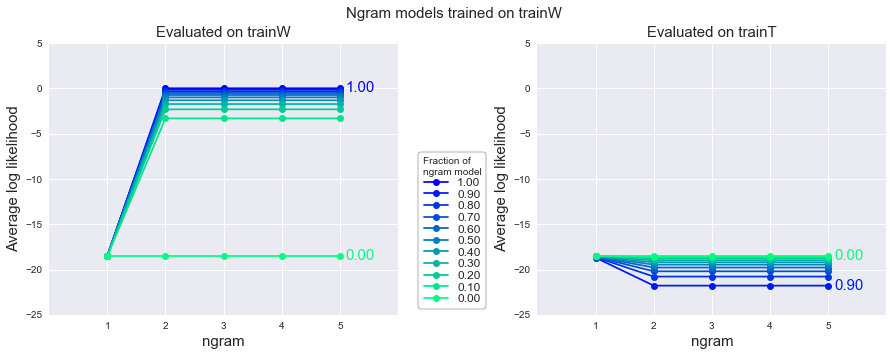

In [319]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Ngram models trained on trainW')
plt.subplots_adjust(wspace=0.4)

plot_interpolate_with_uniform(ax[0], test_condprobsWW, np.arange(0, 1.01, 0.1), ylim=(-25, 5), legend=True)
plot_interpolate_with_uniform(ax[1], test_condprobsWT, np.arange(0, 0.95, 0.1), ylim=(-25, 5))
ax[0].set_title('Evaluated on trainW')
ax[1].set_title('Evaluated on trainT')
fig.savefig('viz/ngram_WW_WT.png')

plt.show()

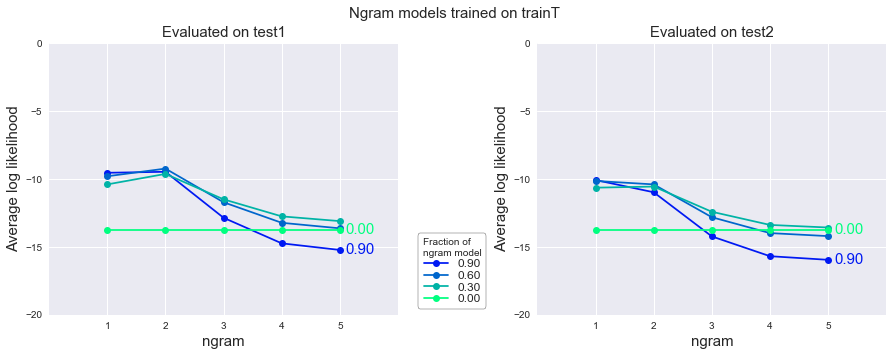

In [320]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Ngram models trained on trainT')
plt.subplots_adjust(wspace=0.4)

plot_interpolate_with_uniform(ax[0], test_condprobsT1, np.arange(0, 0.95, 0.3), legend=True)
plot_interpolate_with_uniform(ax[1], test_condprobsT2, np.arange(0, 0.95, 0.3))
ax[0].set_title('Evaluated on test1', fontsize=15)
ax[1].set_title('Evaluated on test2', fontsize=15)
fig.savefig('viz/ngram_T1_T2.png')

plt.show()

Investigating difference in model performance (trained on trainT) on test1 and test2

In [342]:
avg_ll_T1s_90 = [calculate_avg_ll(test_condprobsT1, [0, n], weights=[0.1, 0.9]) for n in range(1, 6)]
avg_ll_T2s_90 = [calculate_avg_ll(test_condprobsT2, [0, n], weights=[0.1, 0.9]) for n in range(1, 6)]

In [412]:
n_missing_ngrams_T1 = {}
n_missing_ngrams_T2 = {}

for n in range(2, 6):
    trainT_padded = WordCounter(get_tokenized_sentences(file_names_lookup['trainT'], padding=n-1))
    test1_padded = WordCounter(get_tokenized_sentences(file_names_lookup['test1'], padding=n-1))
    test2_padded = WordCounter(get_tokenized_sentences(file_names_lookup['test2'], padding=n-1))
    ngram_model = MultigramModel(trainT_padded, n=n, k=1)
    train_ngrams = set(ngram for ngram in ngram_model.ngram_condprobs if '<UNK>' not in ngram)
    
    ngram_model.calculate_avg_ll(test1_padded)
    n_missing_ngrams_T1[n] = sum(info['count'] for ngram, info in ngram_model.test_info.items() if ngram not in train_ngrams)
    
    ngram_model.calculate_avg_ll(test2_padded)
    n_missing_ngrams_T2[n] = sum(info['count'] for ngram, info in ngram_model.test_info.items() if ngram not in train_ngrams)

In [415]:
n_missing_ngrams_T1[1] = len(set(test1.all_ngram_counts[1]) - set(trainT.all_ngram_counts[1]))
n_missing_ngrams_T2[1] = len(set(test2.all_ngram_counts[1]) - set(trainT.all_ngram_counts[1]))

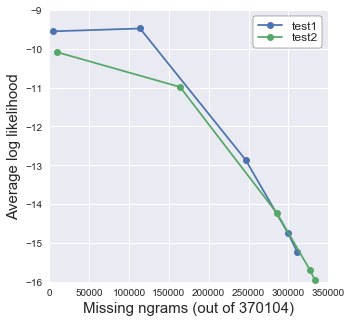

In [428]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([n_missing_ngrams_T1[n] for n in range(1, 6)], avg_ll_T1s_90, 'o-', label='test1', clip_on=False)
ax.plot([n_missing_ngrams_T2[n] for n in range(1, 6)], avg_ll_T2s_90, 'o-', label='test2', clip_on=False)
ax.set_xlabel('Missing ngrams (out of 370104)')
ax.set_ylabel('Average log likelihood')
ax.set_xlim(0, 350000)
ax.set_ylim(-16, -9)

fig.savefig('viz/ missing_vs_avg_ll_T12.png', bbox_inches='tight')

ax.legend(**legend_opts)

In [479]:
unigram_weights = np.arange(0, 1, 0.01)
full_unigram_weights = np.arange(0, 1.01, 0.01)
avg_lls_TT = [calculate_avg_ll(test_condprobsTT, [0, 1], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in full_unigram_weights]
avg_lls_TW = [calculate_avg_ll(test_condprobsTW, [0, 1], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]
avg_lls_T1 = [calculate_avg_ll(test_condprobsT1, [0, 1], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]
avg_lls_T2 = [calculate_avg_ll(test_condprobsT2, [0, 1], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]
avg_lls_T12 = [calculate_avg_ll(np.vstack([test_condprobsT1, test_condprobsT2]), [0, 1], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]

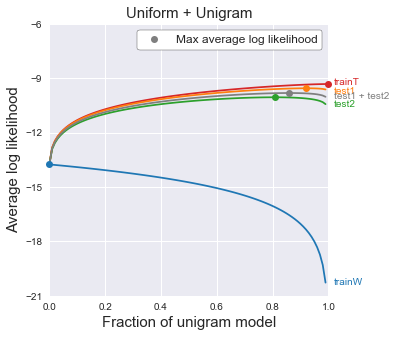

In [483]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(full_unigram_weights, avg_lls_TT, color='tab:red')
ax.plot(unigram_weights, avg_lls_TW, color='tab:blue')
ax.plot(unigram_weights, avg_lls_T1, color='tab:orange')
ax.plot(unigram_weights, avg_lls_T2, color='tab:green')
ax.plot(unigram_weights, avg_lls_T12, color='tab:gray')

ax.text(1.02, avg_lls_TT[-1]+0.1, s='trainT', va='center', color='tab:red', fontsize=10)
ax.text(1.02, avg_lls_TW[-1], s='trainW', va='center', color='tab:blue', fontsize=10)
ax.text(1.02, avg_lls_T1[-1]-0.1, s='test1', va='center', color='tab:orange', fontsize=10)
ax.text(1.02, avg_lls_T2[-1], s='test2', va='center', color='tab:green', fontsize=10)
ax.text(1.02, avg_lls_T12[-1], s='test1 + test2', va='center', color='tab:gray', fontsize=10)

ax.set_xticks(np.arange(0, 1.1, 0.2))
ax.set_yticks(np.arange(-21, -5, 3))
ax.set_xlim(0, 1)
ax.set_ylim(-21, -6)

ax.plot(full_unigram_weights[np.argmax(avg_lls_TT)], max(avg_lls_TT), 'o', color='tab:red', clip_on=False)
ax.plot(unigram_weights[np.argmax(avg_lls_TW)], max(avg_lls_TW), 'o', color='tab:blue', clip_on=False)
ax.plot(unigram_weights[np.argmax(avg_lls_T1)], max(avg_lls_T1), 'o', color='tab:orange', clip_on=False)
ax.plot(unigram_weights[np.argmax(avg_lls_T2)], max(avg_lls_T2), 'o', color='tab:green', clip_on=False)
ax.plot(unigram_weights[np.argmax(avg_lls_T12)], max(avg_lls_T12), 'o', color='tab:gray', clip_on=False)
ax.plot(100, 100, 'o', color='tab:gray', label='Max average log likelihood')

ax.set_xlabel('Fraction of unigram model')
ax.set_ylabel('Average log likelihood')
ax.set_title('Uniform + Unigram', fontsize=15)
ax.legend(**legend_opts)
fig.savefig('viz/bias_variance_with_test1&2.png', bbox_inches='tight')
plt.show()

In [1909]:
cols = []
avg_lls_TT = []
avg_lls_TW = []
avg_lls_T1 = []
avg_lls_T2 = []
labels = []

ns = range(6)
label = ''
for n in ns:
    cols.append(n)
    label += f'{n}\n'
    labels.append(label)
    avg_lls_TT.append(calculate_avg_ll(test_condprobsTT, cols))
    avg_lls_TW.append(calculate_avg_ll(test_condprobsTW, cols))
    avg_lls_T1.append(calculate_avg_ll(test_condprobsT1, cols))
    avg_lls_T2.append(calculate_avg_ll(test_condprobsT2, cols))
    
labels[0] = '0\n(uniform)'

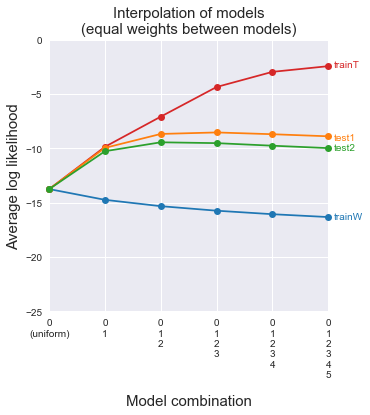

In [1910]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(ns, avg_lls_TT, 'o-', color='tab:red', clip_on=False)
ax.plot(ns, avg_lls_TW, 'o-', color='tab:blue', clip_on=False)
ax.plot(ns, avg_lls_T1, 'o-', color='tab:orange', clip_on=False)
ax.plot(ns, avg_lls_T2, 'o-', color='tab:green', clip_on=False)

ax.text(5.1, avg_lls_TT[-1]+0.1, s='trainT', va='center', color='tab:red', fontsize=10)
ax.text(5.1, avg_lls_TW[-1], s='trainW', va='center', color='tab:blue', fontsize=10)
ax.text(5.1, avg_lls_T1[-1]-0.1, s='test1', va='center', color='tab:orange', fontsize=10)
ax.text(5.1, avg_lls_T2[-1], s='test2', va='center', color='tab:green', fontsize=10)

ax.set_xticks(np.arange(0, 6, 1))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(-25, 1, 5))
ax.set_xlim(0, 5)
ax.set_ylim(-25, 0)

ax.set_xlabel('Model combination')
ax.set_ylabel('Average log likelihood')
ax.set_title('Interpolation of models\n(equal weights between models)', fontsize=15)

fig.savefig('viz/what_combination.png', bbox_inches='tight')
plt.show()

In [64]:
col_combinations = []
for n_models in range(1, 6):
    for combination in combinations(range(1, 6), n_models):
        col_combinations.append((0,) + combination)

In [68]:
avg_lls_combinationsT1 = {}
avg_lls_combinationsT2 = {}
for col_combination in col_combinations:
    avg_lls_combinationsT1[col_combination] = calculate_avg_ll(test_condprobsT1, col_combination)
    avg_lls_combinationsT2[col_combination] = calculate_avg_ll(test_condprobsT2, col_combination)

## EM algorithm

### Animation with toy example and interpolation between uniform and unigram models

In [431]:
def get_avg_ll(p, a0):
    a1 = 1 - a0
    return np.log2(p[:, 0] * a0 + p[:, 1] * (1-a0)).mean()

In [432]:
def get_avg_ll_lower_bound_at_a0(p, a0, b0):
    a1 = 1 - a0
    b1 = 1 - b0
    with np.errstate(invalid='ignore'):
        lower_bound0 = b0 * np.log2(p[:, 0] * a0 / b0)
        lower_bound1 = b1 * np.log2(p[:, 1] * a1 / b1)
        
    lower_bound0[np.isnan(lower_bound0)] = 0
    lower_bound1[np.isnan(lower_bound1)] = 0
    lower_bound_avg_ll = (lower_bound0 + lower_bound1).mean()
    return lower_bound_avg_ll

In [433]:
def get_naive_ll_lower_bound(p, a0):
    a1 = 1 - a0
    return (a0 * np.log2(p[:, 0]) + a1 * np.log2(p[:, 1])).mean()

In [434]:
class EMTwoModel():
    def __init__(self):
        self.tracked_info = {}
        
    def get_b0(self, p, a0):
        a1 = 1 - a0
        nom = p[:, 0] * a0
        denom = p[:, 0] * a0 + p[:, 1] * a1
        b0 = nom / denom
        return b0
    
    def train(self, p, n_iter=100, start_a0=0.5):
        a0 = start_a0
        for i in range(n_iter):
            avg_ll = get_avg_ll(p, a0)
            self.tracked_info[i] = {'a0': a0, 'avg_ll': avg_ll}
            b0 = self.get_b0(p, a0)
            a0 = b0.mean()
        self.tracked_info[i+1] = {'a0': a0, 'avg_ll': get_avg_ll(p, a0)}
        return a0

In [503]:
def update(i, fig, ax, p, em_twomodel, legend_loc='lower right'):
    if i % 10 == 0:
        print(i)
    ax.lines = [ax.lines[0]]
    ax.collections = [ax.collections[0]]
    a0_at_join = em_twomodel.tracked_info[i]['a0']
    a0_at_max = em_twomodel.tracked_info[i+1]['a0']
    b0_at_join = em_twomodel.get_b0(p, a0_at_join)
    avg_ll_at_join = get_avg_ll(p, a0_at_join)
    avg_ll_at_max = get_avg_ll_lower_bound_at_a0(p, a0_at_max, b0_at_join)
    
    
    ax.plot(1-a0s_truncated, [get_avg_ll_lower_bound_at_a0(p, a0, b0_at_join) for a0 in a0s_truncated], color='tab:green', zorder=10, label='Lower bound')
    ax.scatter(1-a0_at_join, avg_ll_at_join, marker='.', color='black', zorder=11, label='E step')
    ax.scatter(1-a0_at_max, avg_ll_at_max, marker='.', color='tab:red', zorder=11, label='M step')
    ax.vlines(1-a0_at_join, -100, avg_ll_at_join, linestyle='--', linewidth=1, color='black')
    ax.vlines(1-a0_at_max, -100, avg_ll_at_max, linestyle='--', linewidth=1, color='tab:red')
    
    ax.set_title(f'Iteration {i}')
    ax.legend(loc=legend_loc, **legend_opts)

Animation for toy example

In [506]:
p = np.array([[0.3, 0.4], [0.3, 0.1], [0.3, 0.5]])
a0s = np.arange(0, 1.01, 0.01)
a0s_truncated = np.arange(0.01, 1, 0.01)

In [507]:
em_twomodel = EMTwoModel()
em_twomodel.train(p, n_iter=50, start_a0=0.1)

0.6714410072107092

0
0
10
20
30
40
0


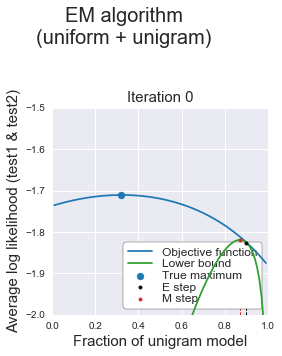

In [508]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.subplots_adjust(left=0.3, top=0.7)
fig.suptitle('EM algorithm\n(uniform + unigram)', fontsize=20)

avg_lls = [get_avg_ll(p, a0) for a0 in a0s_truncated]
a0_at_end = a0s_truncated[np.argmax(avg_lls)]
ax.plot(1-a0s_truncated, avg_lls, color='tab:blue', zorder=10, label='Objective function')
ax.scatter(1-a0_at_end, get_avg_ll(p, a0_at_end), marker='o', color='tab:blue', zorder=10, label='True maximum')
ax.set_xlim(0, 1)
ax.set_ylim(-2, -1.5)
ax.set_xlabel('Fraction of unigram model')
ax.set_ylabel('Average log likelihood (test1 & test2)')


anim = FuncAnimation(fig, lambda i: update(i, fig, ax, p, em_twomodel), 
                     frames=range(len(em_twomodel.tracked_info)-1), interval=150, repeat=True)
anim.save('viz/EM_toy.mp4', writer='ffmpeg')

plt.show()

Animation for actual data

In [509]:
test_condprobsT12_01 = np.vstack([test_condprobsT1[:, [0, 1]], test_condprobsT2[:, [0, 1]]])
p = test_condprobsT12_01
em_twomodel = EMTwoModel()
em_twomodel.train(p, n_iter=10, start_a0=0.5)

0.14011007006133067

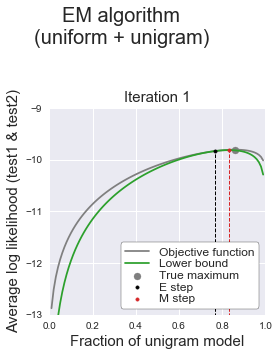

In [510]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.subplots_adjust(left=0.3, top=0.7)
fig.suptitle('EM algorithm\n(uniform + unigram)', fontsize=20)

avg_lls = [get_avg_ll(p, a0) for a0 in a0s_truncated]
a0_at_end = a0s_truncated[np.argmax(avg_lls)]
ax.plot(1-a0s_truncated, avg_lls, color='tab:gray', zorder=10, label='Objective function')
ax.scatter(1-a0_at_end, get_avg_ll(p, a0_at_end), marker='o', color='tab:gray', zorder=10, label='True maximum')
ax.set_xlim(0, 1)
ax.set_yticks(range(-13, -8))
ax.set_ylim(-13, -9)
ax.set_xlabel('Fraction of unigram model')
ax.set_ylabel('Average log likelihood (test1 & test2)')

i = 1
a0_at_join = em_twomodel.tracked_info[i]['a0']
a0_at_max = em_twomodel.tracked_info[i+1]['a0']
b0_at_join = em_twomodel.get_b0(p, a0_at_join)
avg_ll_at_join = get_avg_ll(p, a0_at_join)
avg_ll_at_max = get_avg_ll_lower_bound_at_a0(p, a0_at_max, b0_at_join)


ax.plot(1-a0s_truncated, [get_avg_ll_lower_bound_at_a0(p, a0, b0_at_join) for a0 in a0s_truncated], color='tab:green', zorder=10, label='Lower bound')
ax.scatter(1-a0_at_join, avg_ll_at_join, marker='.', color='black', zorder=11, label='E step')
ax.scatter(1-a0_at_max, avg_ll_at_max, marker='.', color='tab:red', zorder=11, label='M step')
ax.vlines(1-a0_at_join, -20, avg_ll_at_join, linestyle='--', linewidth=1, color='black')
ax.vlines(1-a0_at_max, -20, avg_ll_at_max, linestyle='--', linewidth=1, color='tab:red')

ax.set_title(f'Iteration {i}')
ax.legend(loc='lower right', **legend_opts)
fig.savefig('viz/EMstep1.png', bbox_inches='tight')

0
0
0


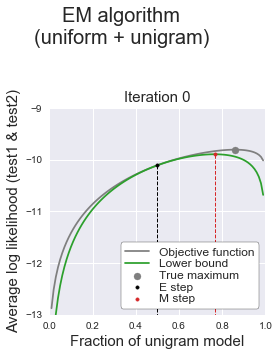

In [514]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.subplots_adjust(left=0.3, top=0.7)
fig.suptitle('EM algorithm\n(uniform + unigram)', fontsize=20)

avg_lls = [get_avg_ll(p, a0) for a0 in a0s_truncated]
a0_at_end = a0s_truncated[np.argmax(avg_lls)]
ax.plot(1-a0s_truncated, avg_lls, color='tab:gray', zorder=10, label='Objective function')
ax.scatter(1-a0_at_end, get_avg_ll(p, a0_at_end), marker='o', color='tab:gray', zorder=10, label='True maximum')
ax.set_xlim(0, 1)
ax.set_yticks(range(-13, -8))
ax.set_ylim(-13, -9)
ax.set_xlabel('Fraction of unigram model')
ax.set_ylabel('Average log likelihood (test1 & test2)')


anim = FuncAnimation(fig, lambda i: update(i, fig, ax, p, em_twomodel, legend_loc='lower right'), 
                     frames=range(len(em_twomodel.tracked_info)-1), interval=500, repeat=True)
anim.save('viz/EM_actual_data.mp4', writer='ffmpeg')

plt.show()

### Comparison with gradient descent for (uniform + unigram) interpolation

In [1590]:
class GradientDescentTwoModel:
    def __init__(self):
        self.tracked_info = {}
    
    def train(self, p, n_iter=100, training_rate=0.005):
        a0 = 0.5
        p0 = p[:, 0]
        p1 = p[:, 1]
        for i in range(n_iter):
            avg_ll = get_avg_ll(p, a0)
            self.tracked_info[i] = {'a0': a0, 'avg_ll': avg_ll}
            a1 = 1 - a0
            weighted_p = p0 * a0 + p1 * a1
            gradient0 = ((p0 - p1) / weighted_p).mean()
            a0 += training_rate * gradient0
        self.tracked_info[i+1] = {'a0': a0, 'avg_ll': get_avg_ll(p, a0)}
        return a0

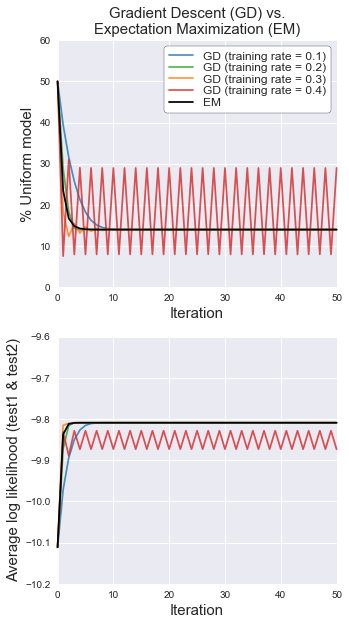

In [1608]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(5, 10))
n_iter = 50
colors_by_training_rate = {0.1: 'tab:blue', 0.2: 'tab:green', 0.3: 'tab:orange', 0.4: 'tab:red'}
for training_rate, color in colors_by_training_rate.items():
    gd_model = GradientDescentTwoModel()
    gd_model.train(test_condprobsT12_01, n_iter, training_rate)
    ax0.plot([gd_model.tracked_info[i]['a0']*100 for i in range(n_iter+1)], label=f'GD (training rate = {training_rate})', color=color, clip_on=False, alpha=0.8)
    ax1.plot([gd_model.tracked_info[i]['avg_ll'] for i in range(n_iter+1)], clip_on=False, color=color, alpha=0.8)
em_twomodel = EMTwoModel()
em_twomodel.train(test_condprobsT12_01)
ax0.plot([em_twomodel.tracked_info[i]['a0']*100 for i in range(n_iter+1)], color='black', label='EM', clip_on=False)
ax1.plot([em_twomodel.tracked_info[i]['avg_ll'] for i in range(n_iter+1)], color='black', clip_on=False)

ax0.set_xlim(0, n_iter)
ax0.set_ylim(0, 60)
# ax0.set_xticks(np.arange(0, n_iter+1))
ax0.set_xlabel('Iteration')
ax0.set_ylabel('% Uniform model')
ax1.set_xlim(0, n_iter)
# ax1.set_xticks(np.arange(0, n_iter+1))
ax1.set_ylim(-10.2, -9.6)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Average log likelihood (test1 & test2)')
ax0.set_title('Gradient Descent (GD) vs.\nExpectation Maximization (EM)', fontsize=15)
legend = ax0.legend(loc='upper right', **legend_opts)
fig.savefig('viz/GD_vs_EM.png', bbox_inches='tight')

### EM algorithm for all models

In [523]:
class EM_Interpolation:
    def __init__(self):
        self.tracked_info = {}
    
    def calculate_weights(self, condprobs, n_iter=20):
        self.n_iter = 10
        n_models = condprobs.shape[1]
        weights = np.ones(n_models) / n_models

        for i in range(n_iter):
            weighted_probs = condprobs * weights
            total_probs = weighted_probs.sum(axis=1)
            avg_ll = np.log2(total_probs).mean()
            self.tracked_info[i] = {'weights': weights, 'avg_ll': avg_ll}

            # E step
            model_contributions = weighted_probs / weighted_probs.sum(axis=1)[:, np.newaxis]

            # M step
            weights = model_contributions.mean(axis=0)
        self.tracked_info[i+1] = {'weights': weights, 'avg_ll': np.log2(total_probs).mean()}
        return weights

In [530]:
test_condprobsT12 = np.vstack([test_condprobsT1[:, :-1], test_condprobsT2[:, :-1]])

In [533]:
em_T12 = EM_Interpolation()
em_weights = em_T12.calculate_weights(test_condprobsT12, n_iter=10)

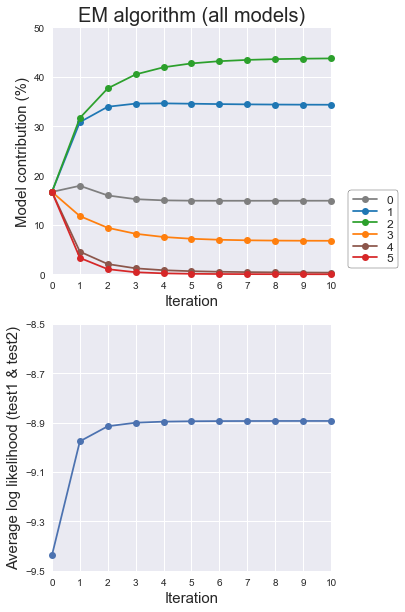

In [532]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(5, 10))
colors_by_model = {0: 'tab:gray', 1: 'tab:blue', 2: 'tab:green', 3: 'tab:orange', 4: 'tab:brown', 5: 'tab:red'}

for j in range(6):
    ax0.plot([100 * em_T12.tracked_info[i]['weights'][j] for i in range(em_T12.n_iter+1)], 'o-', color=colors_by_model[j], label=j, clip_on=False)
ax0.legend(bbox_to_anchor=(1.04, 0), loc='lower left', **legend_opts)
ax0.set_xlim(0, 10)
ax0.set_xticks(np.arange(0, 11))
ax0.set_ylim(0, 50)
ax0.set_xlabel('Iteration')
ax0.set_ylabel('Model contribution (%)')
ax0.set_title('EM algorithm (all models)', fontsize=20)
    
ax1.plot([em_T12.tracked_info[i]['avg_ll'] for i in range(em_T12.n_iter+1)], 'o-', clip_on=False)
ax1.set_xlim(0, 10)
ax1.set_xticks(np.arange(0, 11))
ax1.set_yticks(np.arange(-9.5, -8.4, 0.2))
ax1.set_ylim(-9.5, -8.5)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Average log likelihood (test1 & test2)')
fig.savefig('viz/EM_all.png', bbox_inches='tight')

In [545]:
em_weights

array([1.48858110e-01, 3.43084324e-01, 4.36825655e-01, 6.77906317e-02,
       3.35603022e-03, 8.52486749e-05])

Final benchmark on two other books (similar to test1 and test2)

In [544]:
condprob_modelT = CondProb(trainT)
condprobsT_by_name = {}
testset_names = ['test1', 'test2', 'test3', 'test4']
for testset_name in testset_names:
    condprobsT_by_name[testset_name] = condprob_modelT.get_test_condprobs(f'data/{testset_name}_token_end.txt')

In [549]:
equal_weights_avg_lls = {}
em_weights_avg_lls = {}
for testset_name, condprob in condprobsT_by_name.items():
    equal_weights_avg_lls[testset_name] = calculate_avg_ll(condprob, range(0, 6), weights=None)
    em_weights_avg_lls[testset_name] = calculate_avg_ll(condprob, range(0, 6), weights=em_weights)

In [554]:
colors_by_testset_name = {'test1': 'tab:brown', 'test2': 'tab:green', 'test3': 'tab:orange', 'test4': 'tab:olive'}

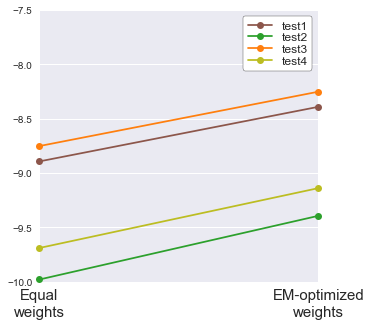

In [579]:
fig, ax = plt.subplots(figsize=(5, 5))
for testset_name in testset_names:
    ax.plot([0, 1], [equal_weights_avg_lls[testset_name], em_weights_avg_lls[testset_name]], 'o-', 
            label=testset_name, color=colors_by_testset_name[testset_name], clip_on=False)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -8)
ax.set_yticks(np.arange(-10, -7, 0.5))
ax.set_xticks([0, 1])
ax.set_xticklabels(['Equal\nweights', 'EM-optimized\nweights'], fontsize=15)
ax.legend(**legend_opts)

fig.savefig('viz/final_EM_benchmark.png', bbox_inches='tight')
